# Two task network 

Network has eight inputs:

1. The fixation. 
1. $u_{rule}^{1}$
1. $u_{rule}^{2}$
1. The first context mod. 
1. The second ontext mod. 
1. The first context status. 
1. The second context status. 
1. The Romo signals.

Network has five outputs: 
1. The fixation. 
1. The first context output. 
1. The second context output. 
1. The first Romo task output. 
1. The second Romo task output. 


<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: Lif


$$\begin{align*}
            \dot{v} &= 1/\tau_{\text{mem}} (v_{\text{leak}} - v + i) \\
            \dot{i} &= -1/\tau_{\text{syn}} i
        \end{align*}
$$ 

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifrefrac import SNNLifRefrac
from cgtasknet.tasks.tasks import MultyTask
from norse.torch.functional.lif_refrac import LIFRefracParameters

## Step -1: Select device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


In [3]:
batch_size = 10
number_of_tasks = 10
task_list = [("WorkingMemory", dict()), (("ContextDM", dict()))]
tasks = dict(task_list)
Task = MultyTask(tasks=tasks, batch_size=15)

## Step 1.1: Create model

In [4]:
feature_size, output_size = Task.feature_and_act_size[0]
hidden_size = 200

neuron_parameters = LIFRefracParameters()
model = SNNLifRefrac(
    feature_size, hidden_size, output_size, neuron_parameters=neuron_parameters
).to(device)

## Step 1.2: Save pre-learning weights

In [5]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

## Step 2: loss and creterion 

In [6]:
learning_rate = 5e-2
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
inputs, target_outputs = Task.dataset(number_of_tasks)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

In [21]:
data = torch.ones(size=(1000, 1, 8)) / 5
from cgtasknet.net.lifrefrac import SNNLIFRefractStates, SNNLIFRefractOneState

one_state = SNNLIFRefractOneState(8, 10, 1)
state = SNNLIFRefractStates(one_state)
out, v, z = state.generate_states(data)

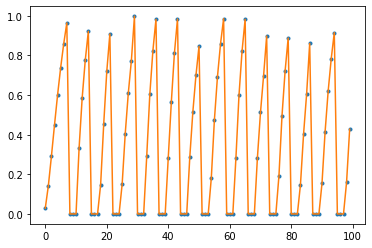

In [25]:
plt.plot(v.detach().cpu().numpy()[:100, 0, 0], ".")
plt.plot(v.detach().cpu().numpy()[:100, 0, 0], "-")